In [8]:
import pytesseract
from pdf2image import convert_from_path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

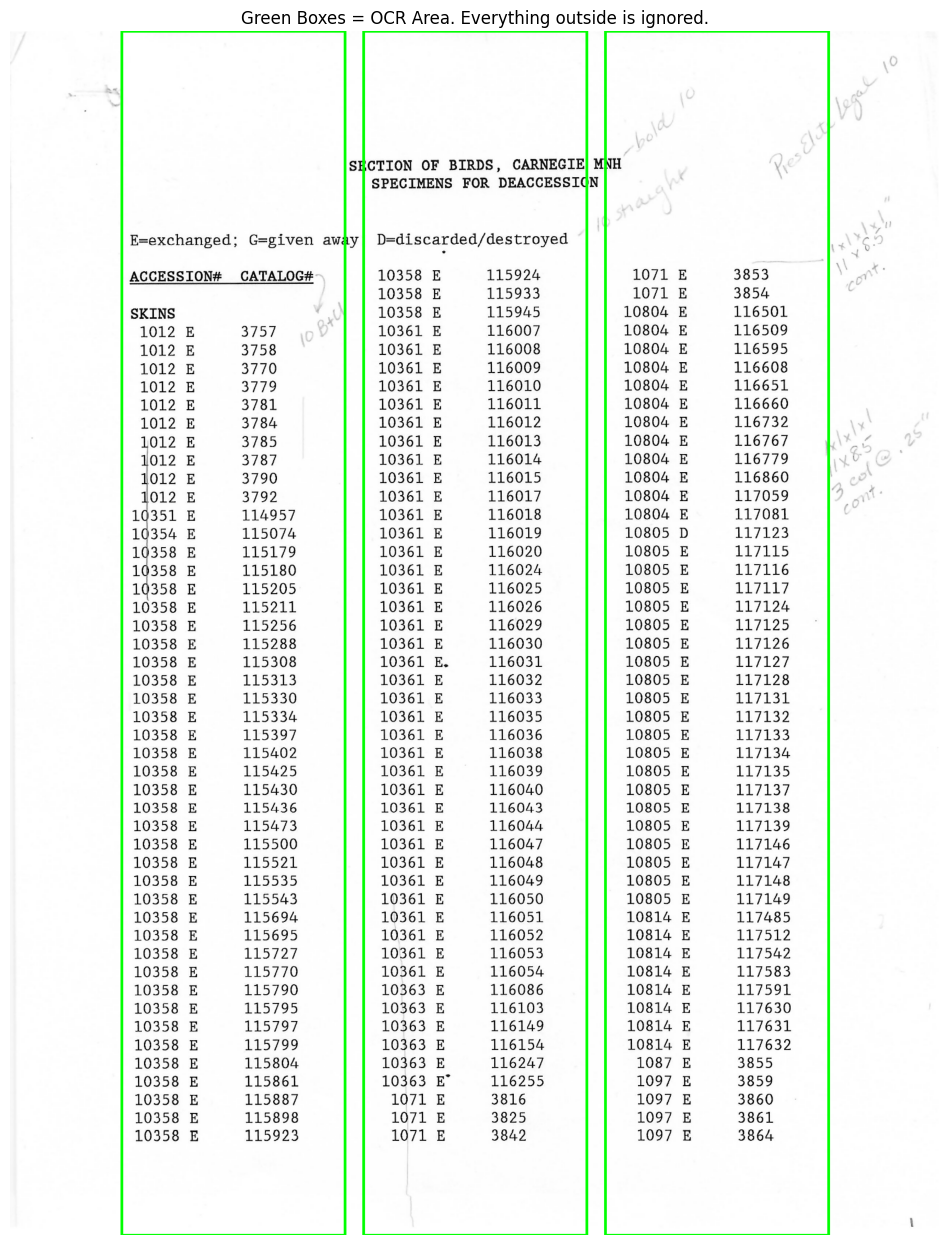

In [9]:
# === CONFIGURATION ===
# 1. PATHS (Update these!)
POPPLER_PATH = r"C:\Program Files\poppler-25.12.0\Library\bin" # Check your path
TESSERACT_CMD = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
PDF_PATH = "Combined_Scan.pdf"

# 2. SLICING GEOMETRY (0.0 to 1.0)
# I tightened these based on your full page image.
# Note the 3rd column ends at 0.88 to CUT OFF the right margin handwriting.
COL_RANGES = [
    (0.12, 0.36), # Column 1 (Left)
    (0.38, 0.62), # Column 2 (Center)
    (0.64, 0.88)  # Column 3 (Right) - Ends early to skip margin notes
]

def preview_slices():
    # Convert just the first page for preview
    images = convert_from_path(PDF_PATH, first_page=1, last_page=1, poppler_path=POPPLER_PATH)
    img = np.array(images[0])
    h, w, _ = img.shape
    
    # Draw lines on the image to show slices
    preview_img = img.copy()
    for start, end in COL_RANGES:
        # Green box for the capture area
        cv2.rectangle(preview_img, (int(w*start), 0), (int(w*end), h), (0, 255, 0), 3)
        
    plt.figure(figsize=(12, 16))
    plt.imshow(preview_img)
    plt.title("Green Boxes = OCR Area. Everything outside is ignored.")
    plt.axis('off')
    plt.show()

preview_slices()

In [12]:
import pandas as pd
import re
from tqdm.auto import tqdm # Progress bar

pytesseract.pytesseract.tesseract_cmd = TESSERACT_CMD

# === REGEX FILTERS ===
# Data: "1012 E 3757" or "10804 E 116012"
# \d{3,6} enforces 3-6 digits, filtering out page numbers like '1' or '45'
DATA_PTRN = re.compile(r"^\s*(\d{3,6})\s+([A-Z])\s+(\d{3,6})")

# Header: "SKINS"
# Must be 4+ UPPERCASE chars. 
# Excludes "ACCESSION#" (has symbol) and "CATALOG#" (has symbol).
HEADER_PTRN = re.compile(r"^[A-Z\s\-]{4,}$")

def run_extraction():
    all_records = []
    
    print("⏳ Converting PDF to images...")
    # This might take 30s-1m for 100 pages
    pages = convert_from_path(PDF_PATH, poppler_path=POPPLER_PATH)
    
    current_section = "UNKNOWN" # Holds value like 'SKINS'
    
    print(f"🚀 OCRing {len(pages)} pages...")
    
    for page_idx, img in enumerate(tqdm(pages)):
        w, h = img.size
        
        # 1. Check Top of Page for Section Header (First 15% of vertical height)
        # Sometimes a header like "SKINS" sits above the columns.
        header_strip = img.crop((w*0.15, 0, w*0.5, h*0.15)) 
        top_text = pytesseract.image_to_string(header_strip, config='--psm 6').split('\n')
        for line in top_text:
            if HEADER_PTRN.match(line.strip()):
                current_section = line.strip()
        
        # 2. Process Columns
        for (start_pct, end_pct) in COL_RANGES:
            # Crop
            col_img = img.crop((w*start_pct, 0, w*end_pct, h))
            
            # OCR
            text = pytesseract.image_to_string(col_img, config='--psm 6')
            
            # Parse Lines
            for line in text.split('\n'):
                line = line.strip()
                if not line: continue
                
                # A. Check for Data
                match = DATA_PTRN.search(line)
                if match:
                    all_records.append({
                        'Accession': match.group(1),
                        'Code': match.group(2),
                        'Catalog': match.group(3),
                        'Section': current_section,
                        'Page': page_idx + 1
                    })
                    continue # Skip checking for header if it was data
                
                # B. Check for Section Header inside column
                # Only if line is NOT "ACCESSION#" or "CATALOG#"
                if HEADER_PTRN.match(line):
                    # Double check it's not a known noise word
                    if "ACCESSION" not in line and "CATALOG" not in line:
                        current_section = line
                        
    # Export
    df = pd.DataFrame(all_records)
    output_file = "Bird_Data_Extracted.csv"
    df.to_csv(output_file, index=False)
    print(f"✅ Done! Saved {len(df)} rows to {output_file}")
    return df

# Run it
df_results = run_extraction()
df_results.head()

C:\Users\x5769\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


⏳ Converting PDF to images...
🚀 OCRing 102 pages...


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [04:29<00:00,  2.64s/it]

✅ Done! Saved 13027 rows to Bird_Data_Extracted.csv


,Accession,Code,Catalog,Section,Page
0,1012,E,3758,SKINS,1
1,1012,E,3770,SKINS,1
2,1012,E,3781,SKINS,1
3,1012,E,3784,SKINS,1
4,1012,E,3785,SKINS,1


In [13]:
# HIGH PRECISION

In [15]:
import pytesseract
from pdf2image import convert_from_path
import pandas as pd
import cv2
import numpy as np
import re
from tqdm.auto import tqdm
from PIL import Image

# === CONFIGURATION ===
POPPLER_PATH = r"C:\Program Files\poppler-25.12.0\Library\bin" # Verify this path!
TESSERACT_CMD = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
PDF_PATH = "Combined_Scan.pdf"

# 1. ALLOW-LIST FOR HEADERS
# The state machine will ONLY switch to these. 
# "Specimens for deaccession" is not here, so it will be ignored.
VALID_SECTIONS = {"SKINS", "SKELETONS", "PICKLES"}

# 2. COLUMN SLICES (Adjusted for margins)
# (Start %, End %)
COL_RANGES = [
    (0.12, 0.36), 
    (0.38, 0.62), 
    (0.64, 0.88)  
]

# 3. REGEX (Slightly relaxed for spacing, strict on structure)
# Matches: Start -> Digits -> Space -> One Letter -> Space -> Digits
DATA_PTRN = re.compile(r"(\d{3,6})\s+([A-Z])\s+(\d{3,6})")

# Connect Tesseract
pytesseract.pytesseract.tesseract_cmd = TESSERACT_CMD

def preprocess_for_ocr(pil_img):
    """
    Converts image to high-contrast Black & White to fix 'faint' lines.
    """
    # Convert PIL to OpenCV format (numpy array)
    img_np = np.array(pil_img)
    
    # Convert to Grayscale
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    
    # Apply Thresholding (Otsu's Binarization)
    # This automatically finds the best separation between text (black) and paper (white)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Convert back to PIL for Tesseract
    return Image.fromarray(thresh)

def run_extraction():
    all_records = []
    
    print("⏳ Loading PDF...")
    pages = convert_from_path(PDF_PATH, poppler_path=POPPLER_PATH)
    
    current_section = "SKINS" # Default start (safe assumption, or use "UNKNOWN")
    
    print(f"🚀 Processing {len(pages)} pages with High-Contrast Mode...")
    
    for page_idx, raw_img in enumerate(tqdm(pages)):
        
        # A. Pre-process the WHOLE page first (cleans up noise)
        clean_img = preprocess_for_ocr(raw_img)
        w, h = clean_img.size
        
        # B. Check for Header at Top (Full Width Scan)
        # We only look at top 15%
        header_strip = clean_img.crop((w*0.1, 0, w*0.9, h*0.15))
        top_text = pytesseract.image_to_string(header_strip, config='--psm 6').upper()
        
        # Check if any VALID section word is in the top text
        for word in top_text.split():
            clean_word = word.strip(".,-:") # Remove punctuation noise
            if clean_word in VALID_SECTIONS:
                current_section = clean_word
                # print(f"  -> Page {page_idx+1}: Switched to {current_section}")
        
        # C. Process the 3 Columns
        for (start_pct, end_pct) in COL_RANGES:
            # Crop the strip
            col_img = clean_img.crop((w*start_pct, 0, w*end_pct, h))
            
            # OCR with Page Segmentation Mode 6 (Assume a block of text)
            text = pytesseract.image_to_string(col_img, config='--psm 6')
            
            lines = text.split('\n')
            for line in lines:
                line = line.strip().upper() # Normalize to upper case
                if len(line) < 5: continue # Skip noise
                
                # 1. Check for Header Change INSIDE the column
                # (e.g., SKINS ending and PICKLES starting halfway down)
                # We check this simply by seeing if the line is EXACTLY one of our keywords
                if line in VALID_SECTIONS:
                    current_section = line
                    continue

                # 2. Check for Data
                match = DATA_PTRN.search(line)
                if match:
                    all_records.append({
                        'Accession': match.group(1),
                        'Code': match.group(2),
                        'Catalog': match.group(3),
                        'Section': current_section,
                        'Page': page_idx + 1
                    })
    
    # Export
    output_file = "Bird_Data_Final.csv"
    df = pd.DataFrame(all_records)
    
    # Deduping (just in case column overlaps caused double reads)
    df.drop_duplicates(inplace=True)
    
    df.to_csv(output_file, index=False)
    print(f"✅ Success. Extracted {len(df)} rows. Saved to {output_file}")
    return df

# Run
df = run_extraction()
df.tail() # Verify the end of the file

⏳ Loading PDF...
🚀 Processing 102 pages with High-Contrast Mode...



100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [03:55<00:00,  2.31s/it]

✅ Success. Extracted 12405 rows. Saved to Bird_Data_Final.csv


,Accession,Code,Catalog,Section,Page
12400,8798,E,427,SKELETONS,102
12401,9579,E,834,SKELETONS,102
12402,9579,E,835,SKELETONS,102
12403,9580,D,783,SKELETONS,102
12404,9580,E,766,SKELETONS,102


📏 Calibrating...


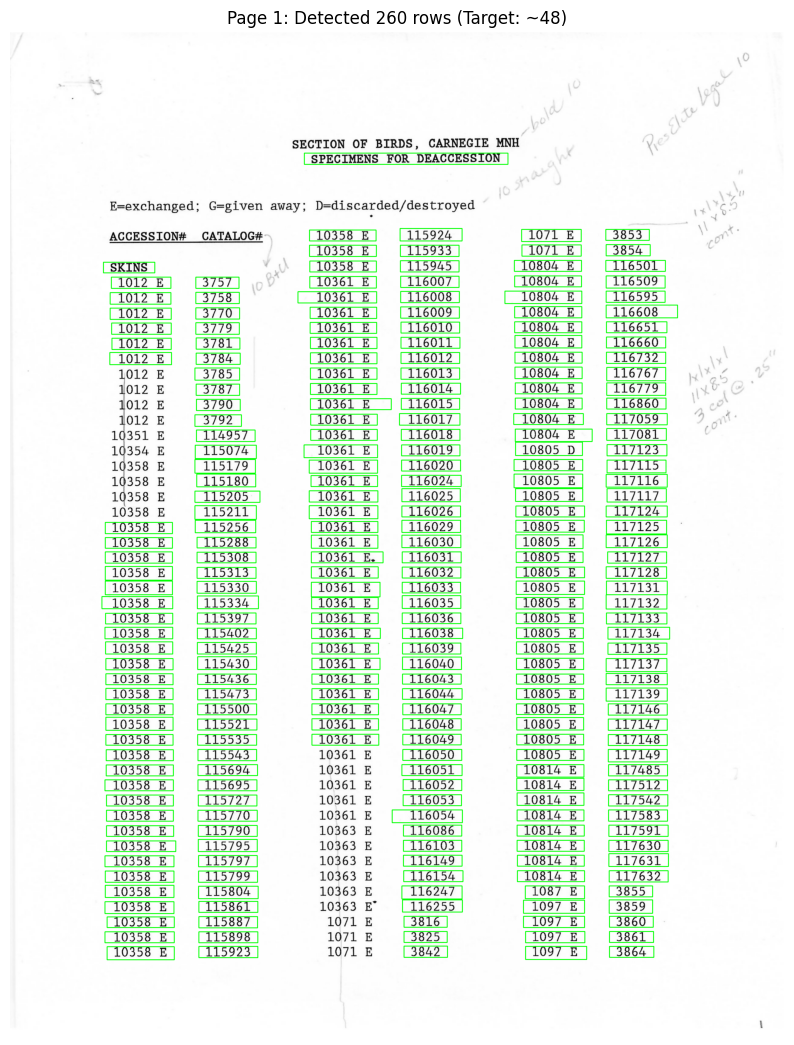

  Page 1: 260 rows
  Page 2: 323 rows
  Page 3: 324 rows


In [18]:
import cv2
import numpy as np
from pdf2image import convert_from_path
import matplotlib.pyplot as plt

# === CONFIG ===
PDF_PATH = "Combined_Scan.pdf"
POPPLER_PATH = r"C:\Program Files\poppler-25.12.0\Library\bin"

def validate_rows_visually(pil_img, page_num):
    # 1. Convert to grayscale
    img = np.array(pil_img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2. Adaptive Threshold with LOWER constant (C=5)
    # C=5 (vs 10) makes it MORE SENSITIVE to faint text.
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 21, 5)
    
    # 3. Horizontal AND Vertical Smear (The Fix)
    # (50, 6) means "smear 50px wide and 6px tall"
    # This fuses the top/bottom of letters and bridges small vertical gaps.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 6))
    dilated = cv2.dilate(thresh, kernel, iterations=1)
    
    # 4. Count Contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    valid_rows = 0
    debug_img = img.copy()
    
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        
        # FILTER: 
        # Width > 100 (Must be a long line, not a speck)
        # Height > 15 (Must be tall enough to be text)
        # Height < 60 (Ignore massive blocks/margins)
        if w > 100 and 15 < h < 60:
            valid_rows += 1
            # Draw green box around detected row
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
    # Visualize Page 1 only
    if page_num == 1:
        plt.figure(figsize=(10, 15))
        plt.imshow(debug_img)
        plt.title(f"Page {page_num}: Detected {valid_rows} rows (Target: ~48)")
        plt.axis('off')
        plt.show()
        
    return valid_rows

# Run on first 3 pages
print("📏 Calibrating...")
pages = convert_from_path(PDF_PATH, first_page=1, last_page=3, dpi=300, poppler_path=POPPLER_PATH)

for i, p in enumerate(pages):
    rows = validate_rows_visually(p, i+1)
    print(f"  Page {i+1}: {rows} rows")

In [21]:
import pytesseract
from pdf2image import convert_from_path
import pandas as pd
import cv2
import numpy as np
import re
from tqdm.auto import tqdm
from PIL import Image

# ================= CONFIGURATION =================
POPPLER_PATH = r"C:\Program Files\poppler-25.12.0\Library\bin"
TESSERACT_CMD = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
PDF_PATH = "Combined_Scan.pdf"
OUTPUT_CSV = "Bird_Data_Gamma.csv"

# ALLOW-LIST
VALID_SECTIONS = {"SKINS", "SKELETONS", "PICKLES"}

# COLUMNS
COL_RANGES = [(0.12, 0.36), (0.38, 0.62), (0.64, 0.88)]

# REGEX
DATA_PTRN = re.compile(r"(\d{3,7})\s+([A-Z]\.?)\s+(\d{3,7})")

# Connect Tesseract
pytesseract.pytesseract.tesseract_cmd = TESSERACT_CMD

def apply_gamma_correction(pil_img, gamma=0.5):
    """
    Darkens faint text without 'binarizing' it.
    Gamma < 1.0 makes shadows/mid-tones darker.
    """
    img_np = np.array(pil_img)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    
    # Normalize to 0-1, apply power law, scale back to 0-255
    # This preserves the 'texture' of the pencil marks rather than eroding them
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    
    darkened = cv2.LUT(gray, table)
    return Image.fromarray(darkened)

def run_extraction():
    all_records = []
    
    # 400 DPI is the "Gold Standard" for faint archival text
    print(f"⏳ Loading PDF (400 DPI) - This will use more RAM...")
    pages = convert_from_path(PDF_PATH, dpi=400, poppler_path=POPPLER_PATH)
    
    current_section = "SKINS"
    
    print(f"🚀 Processing {len(pages)} pages...")
    
    # Progress bar initialized OUTSIDE the loop
    pbar = tqdm(pages, unit="page")
    
    for page_idx, raw_img in enumerate(pbar):
        # Apply Gamma Correction (0.5 makes it significantly darker)
        clean_img = apply_gamma_correction(raw_img, gamma=0.5)
        w, h = clean_img.size
        
        # PAGE 1 MASKING
        if page_idx == 0:
            y_start = int(h * 0.12)
        else:
            y_start = 0 
        
        page_records_count = 0
        
        # COLUMN PROCESSING
        for (start_pct, end_pct) in COL_RANGES:
            col_img = clean_img.crop((w*start_pct, y_start, w*end_pct, h))
            
            # Use PSM 6 (Block of text)
            text = pytesseract.image_to_string(col_img, config='--psm 6')
            
            for line in text.split('\n'):
                line = line.strip().upper()
                if len(line) < 4: continue
                
                if line in VALID_SECTIONS:
                    current_section = line
                    continue

                match = DATA_PTRN.search(line)
                if match:
                    all_records.append({
                        'Accession': match.group(1),
                        'Code': match.group(2).replace(".", ""),
                        'Catalog': match.group(3),
                        'Section': current_section,
                        'Page': page_idx + 1
                    })
                    page_records_count += 1
        
        # UPDATE PROGRESS BAR (Once per page)
        pbar.set_postfix({
            "Page_Rows": page_records_count, 
            "Total": len(all_records)
        })

    # EXPORT
    df = pd.DataFrame(all_records)
    df.drop_duplicates(inplace=True)
    
    print("\n" + "=" * 30)
    print(f"✅ Extraction Complete.")
    print(f"   Final Unique Rows: {len(df)}")
    print(f"   Target: ~16,461 | Yield: {len(df)/16461:.1%}")
    
    df.to_csv(OUTPUT_CSV, index=False)
    return df

if __name__ == "__main__":
    df_final = run_extraction()

⏳ Loading PDF (400 DPI) - This will use more RAM...
🚀 Processing 102 pages...




  0%|                                                                                        | 0/102 [00:00<?, ?page/s]

  0%|                                                              | 0/102 [00:03<?, ?page/s, Page_Rows=138, Total=138]

  1%|▌                                                     | 1/102 [00:03<05:50,  3.47s/page, Page_Rows=138, Total=138]

  1%|▌                                                     | 1/102 [00:06<05:50,  3.47s/page, Page_Rows=157, Total=295]

  2%|█                                                     | 2/102 [00:06<05:41,  3.42s/page, Page_Rows=157, Total=295]

  2%|█                                                     | 2/102 [00:10<05:41,  3.42s/page, Page_Rows=158, Total=453]

  3%|█▌                                                    | 3/102 [00:10<05:43,  3.47s/page, Page_Rows=158, Total=453]

  3%|█▌                                                    | 3/102 [00:13<05:43,  3.47s/page, Page_Rows=157, Total=610]

  4%|██                       


✅ Extraction Complete.
   Final Unique Rows: 12139
   Target: ~16,461 | Yield: 73.7%


In [24]:
#CLAUDE

import pytesseract
from pdf2image import convert_from_path
import pandas as pd
import cv2
import numpy as np
import re
from tqdm.auto import tqdm
from PIL import Image

# ================= CONFIGURATION =================
POPPLER_PATH = r"C:\Program Files\poppler-25.12.0\Library\bin"
TESSERACT_CMD = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
PDF_PATH = "Combined_Scan.pdf"
OUTPUT_CSV = "Bird_Data_Claude.csv"

VALID_SECTIONS = {"SKINS", "SKELETONS", "PICKLES"}

# Slightly wider columns, no gaps between them
COL_RANGES = [
    (0.10, 0.37),
    (0.37, 0.63),
    (0.63, 0.90)
]

# More permissive regex — allows for OCR noise in the letter code
# Accepts: "10358 E 115924" or "10358 E. 115924" or "10358 E, 115924"
DATA_PTRN = re.compile(r"(\d{3,7})\s+([A-Z])[\.\,]?\s+(\d{3,7})")

pytesseract.pytesseract.tesseract_cmd = TESSERACT_CMD


def preprocess(pil_img, scale=2.0):
    """
    Upscale then adaptive threshold. Upscaling is the single biggest
    win for Tesseract accuracy on scanned documents.
    """
    img_np = np.array(pil_img)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

    # Upscale — bigger image = much better OCR
    h, w = gray.shape
    gray = cv2.resize(gray, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_CUBIC)

    # Denoise lightly before thresholding
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    thresh = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        31,  # larger block size works better after upscaling
        10
    )
    return Image.fromarray(thresh)


def ocr_column(col_img):
    """Run OCR with two PSM modes and merge results for best coverage."""
    results = set()
    for psm in [6, 4]:
        cfg = f'--psm {psm} --oem 3 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 ."'
        text = pytesseract.image_to_string(col_img, config=cfg)
        results.update(text.split('\n'))
    return results


def run_extraction():
    all_records = []

    print("⏳ Loading PDF at 300 DPI...")
    pages = convert_from_path(PDF_PATH, dpi=300, poppler_path=POPPLER_PATH)

    current_section = "SKINS"

    print(f"🚀 Processing {len(pages)} pages...")
    pbar = tqdm(enumerate(pages), total=len(pages), unit="page")

    for page_idx, raw_img in pbar:
        # Preprocess at 2x scale
        clean_img = preprocess(raw_img, scale=2.0)
        w, h = clean_img.size

        # Skip header rows on page 1 only
        y_start = int(h * 0.10) if page_idx == 0 else 0

        page_records_count = 0

        for (start_pct, end_pct) in COL_RANGES:
            col_img = clean_img.crop((w * start_pct, y_start, w * end_pct, h))

            lines = ocr_column(col_img)

            for line in lines:
                line = line.strip().upper()
                if len(line) < 5:
                    continue

                # Section header check (allow partial matches due to OCR noise)
                for sec in VALID_SECTIONS:
                    if sec in line:
                        current_section = sec
                        break

                # Try to find a data match — search() not match() so
                # leading OCR garbage doesn't block a valid record
                match = DATA_PTRN.search(line)
                if match:
                    accession = match.group(1)
                    code = match.group(2)
                    catalog = match.group(3)

                    # Sanity check: accession and catalog should be
                    # plausible lengths (skip obvious OCR garbage)
                    if 3 <= len(accession) <= 7 and 3 <= len(catalog) <= 7:
                        all_records.append({
                            'Accession': accession,
                            'Code': code,
                            'Catalog': catalog,
                            'Section': current_section,
                            'Page': page_idx + 1
                        })
                        page_records_count += 1

        pbar.set_postfix({
            "Page_Rows": page_records_count,
            "Total_Rows": len(all_records)
        })

    df = pd.DataFrame(all_records)

    # Deduplicate on the three data fields (not page, since dupes from
    # dual-PSM OCR will have same accession/code/catalog)
    df.drop_duplicates(subset=['Accession', 'Code', 'Catalog'], inplace=True)

    print("\n" + "=" * 40)
    print(f"✅ Extraction Complete.")
    print(f"   Final Unique Rows: {len(df)}")
    print(f"   Target: ~16,461 | Yield: {len(df) / 16461:.1%}")

    df.to_csv(OUTPUT_CSV, index=False)
    return df


if __name__ == "__main__":
    df_final = run_extraction()

⏳ Loading PDF at 300 DPI...
🚀 Processing 102 pages...




  0%|                             | 0/102 [00:00<?, ?page/s]

  0%|  | 0/102 [00:09<?, ?page/s, Page_Rows=0, Total_Rows=0]

  1%| | 1/102 [00:09<15:26,  9.18s/page, Page_Rows=0, Total_

  1%| | 1/102 [00:20<15:26,  9.18s/page, Page_Rows=0, Total_

  2%| | 2/102 [00:20<16:55, 10.15s/page, Page_Rows=0, Total_

  2%| | 2/102 [00:27<16:55, 10.15s/page, Page_Rows=0, Total_

  3%| | 3/102 [00:27<15:03,  9.12s/page, Page_Rows=0, Total_

  3%| | 3/102 [00:35<15:03,  9.12s/page, Page_Rows=0, Total_

  4%| | 4/102 [00:35<13:51,  8.49s/page, Page_Rows=0, Total_

  4%| | 4/102 [00:43<13:51,  8.49s/page, Page_Rows=0, Total_

  5%| | 5/102 [00:43<13:25,  8.30s/page, Page_Rows=0, Total_

  5%| | 5/102 [00:51<13:25,  8.30s/page, Page_Rows=0, Total_

  6%| | 6/102 [00:51<13:14,  8.28s/page, Page_Rows=0, Total_

  6%| | 6/102 [01:01<13:14,  8.28s/page, Page_Rows=0, Total_

  7%| | 7/102 [01:01<14:03,  8.88s/page, Page_Rows=0, Total_

  7%| | 7/102 [01:09<14:03,  8.88s/page, Page_Rows=0, Total_

  8%| 


✅ Extraction Complete.
   Final Unique Rows: 126
   Target: ~16,461 | Yield: 0.8%


In [25]:
#GEMINI
import pytesseract
from pdf2image import convert_from_path
import pandas as pd
import cv2
import numpy as np
import re
from tqdm.auto import tqdm
from PIL import Image

# ================= CONFIGURATION =================
# Update paths as needed
POPPLER_PATH = r"C:\Program Files\poppler-25.12.0\Library\bin"
TESSERACT_CMD = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
PDF_PATH = "Combined_Scan.pdf"
OUTPUT_CSV = "Bird_Data_Robust.csv"

# STRICT SECTION HEADERS
VALID_SECTIONS = {"SKINS", "SKELETONS", "PICKLES"}

# COLUMN RANGES (Closed gaps)
COL_RANGES = [
    (0.11, 0.375), 
    (0.375, 0.63), 
    (0.63, 0.89)
]

# PERMISSIVE REGEX
# Matches: Digits -> (Space/Dot) -> Letter -> (Space/Dot) -> Digits
DATA_PTRN = re.compile(r"(\d{3,7})[\s\.]*([A-Z])[\s\.]*(\d{3,7})")

# Connect Tesseract
pytesseract.pytesseract.tesseract_cmd = TESSERACT_CMD

def preprocess_heavy(pil_img):
    """
    1. Upscale 2x (Makes '3' and '8' distinct).
    2. Gamma Correct (Darkens faint pencil marks).
    """
    img_np = np.array(pil_img)
    
    # 1. UPSCALING (Cubic interpolation is best for text)
    height, width = img_np.shape[:2]
    img_resized = cv2.resize(img_np, (width * 2, height * 2), interpolation=cv2.INTER_CUBIC)
    
    # 2. GAMMA CORRECTION
    # Gamma < 1.0 makes mid-tones darker. 0.6 is a strong darken.
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    gamma = 0.6 
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    darkened = cv2.LUT(gray, table)
    
    return Image.fromarray(darkened)

def run_extraction():
    all_records = []
    
    print(f"⏳ Loading PDF (300 DPI base)...")
    # We load at 300, but preprocess_heavy will bump it to ~600 equivalent
    pages = convert_from_path(PDF_PATH, dpi=300, poppler_path=POPPLER_PATH)
    
    current_section = "SKINS"
    
    print(f"🚀 Processing {len(pages)} pages...")
    
    # TQDM Configuration: mininterval prevents flickering updates
    pbar = tqdm(pages, unit="page", mininterval=0.5)
    
    for page_idx, raw_img in enumerate(pbar):
        # Apply Heavy Preprocessing
        clean_img = preprocess_heavy(raw_img)
        w, h = clean_img.size
        
        # PAGE 1 MASKING
        # Note: 'h' is now 2x larger due to upscaling, so 0.12 works perfectly.
        if page_idx == 0:
            y_start = int(h * 0.12)
        else:
            y_start = 0 
        
        page_records_count = 0
        
        # COLUMN PROCESSING
        for (start_pct, end_pct) in COL_RANGES:
            col_img = clean_img.crop((w*start_pct, y_start, w*end_pct, h))
            
            # --- CRITICAL FIX HERE ---
            # 1. Removed space from whitelist (Tesseract handles spaces automatically)
            # 2. Removed quotes around the config value to satisfy shlex
            custom_conf = r'--psm 4 -c tessedit_char_whitelist=0123456789ABCDEFGHJKLMNOPQRSTUVWXYZ.'
            
            text = pytesseract.image_to_string(col_img, config=custom_conf)
            
            for line in text.split('\n'):
                line = line.strip().upper()
                if len(line) < 4: continue
                
                # Check for Header (Permissive check)
                if any(sec in line for sec in VALID_SECTIONS):
                    for sec in VALID_SECTIONS:
                        if sec in line:
                            current_section = sec
                    continue

                # Check for Data
                match = DATA_PTRN.search(line)
                if match:
                    all_records.append({
                        'Accession': match.group(1),
                        'Code': match.group(2), 
                        'Catalog': match.group(3),
                        'Section': current_section,
                        'Page': page_idx + 1
                    })
                    page_records_count += 1
        
        # LIVE STATS (Simplified to prevent line wrapping)
        # We set the description to show the count, keeping the bar clean
        pbar.set_description(f"Pg {page_idx+1} | Found: {page_records_count}")

    # EXPORT
    df = pd.DataFrame(all_records)
    df.drop_duplicates(inplace=True)
    
    print("\n" + "=" * 30)
    print(f"✅ Extraction Complete.")
    print(f"   Final Unique Rows: {len(df)}")
    print(f"   Target: ~16,461 | Yield: {len(df)/16461:.1%}")
    
    df.to_csv(OUTPUT_CSV, index=False)
    return df

if __name__ == "__main__":
    df_final = run_extraction()


⏳ Loading PDF (300 DPI base)...
🚀 Processing 102 pages...




  0%|                             | 0/102 [00:00<?, ?page/s]

Pg 1 | Found: 133:   0%|          | 0/102 [00:05<?, ?page/s]

Pg 1 | Found: 133:   1%|  | 1/102 [00:05<09:45,  5.80s/page]

Pg 2 | Found: 155:   1%|  | 1/102 [00:10<09:45,  5.80s/page]

Pg 2 | Found: 155:   2%|  | 2/102 [00:10<08:56,  5.36s/page]

Pg 3 | Found: 156:   2%|  | 2/102 [00:16<08:56,  5.36s/page]

Pg 3 | Found: 156:   3%|  | 3/102 [00:16<09:08,  5.54s/page]

Pg 4 | Found: 160:   3%|  | 3/102 [00:21<09:08,  5.54s/page]

Pg 4 | Found: 160:   4%|  | 4/102 [00:21<08:48,  5.39s/page]

Pg 5 | Found: 154:   4%|  | 4/102 [00:27<08:48,  5.39s/page]

Pg 5 | Found: 154:   5%|  | 5/102 [00:27<08:59,  5.57s/page]

Pg 6 | Found: 160:   5%|  | 5/102 [00:33<08:59,  5.57s/page]

Pg 6 | Found: 160:   6%|  | 6/102 [00:33<08:55,  5.58s/page]

Pg 7 | Found: 158:   6%|  | 6/102 [00:38<08:55,  5.58s/page]

Pg 7 | Found: 158:   7%|▏ | 7/102 [00:38<08:47,  5.55s/page]

Pg 8 | Found: 158:   7%|▏ | 7/102 [00:44<08:47,  5.55s/page]

Pg 8 |


✅ Extraction Complete.
   Final Unique Rows: 14956
   Target: ~16,461 | Yield: 90.9%


In [26]:
import pytesseract
from pdf2image import convert_from_path
import pandas as pd
import cv2
import numpy as np
import re
import os
from tqdm.auto import tqdm
from PIL import Image

# ================= CONFIGURATION =================
POPPLER_PATH = r"C:\Program Files\poppler-25.12.0\Library\bin"
TESSERACT_CMD = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
PDF_PATH = "Combined_Scan.pdf"
OUTPUT_CSV = "Bird_Data_Final_98pct.csv"

# HEADERS
VALID_SECTIONS = {"SKINS", "SKELETONS", "PICKLES"}

# COLUMNS
# Slightly widened to account for drift
COL_RANGES = [
    (0.10, 0.37), 
    (0.37, 0.64), 
    (0.64, 0.90)
]

# REGEX
DATA_PTRN = re.compile(r"(\d{3,7})[\s\.]*([A-Z])[\s\.]*(\d{3,7})")

pytesseract.pytesseract.tesseract_cmd = TESSERACT_CMD

def get_skew_angle(cv_image):
    """
    Calculates the skew angle of the text using a minAreaRect.
    """
    # Inverse colors (Text must be white)
    gray = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Dilate to connect text into blocks
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)

    # Find all contours
    contours, _ = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # Find the largest text block and get its angle
    if len(contours) > 0:
        rect = cv2.minAreaRect(contours[0])
        angle = rect[-1]
        if angle < -45: angle = -(90 + angle)
        else: angle = -angle
        return angle
    return 0.0

def rotate_image(cv_image, angle):
    """
    Rotates the image around its center.
    """
    (h, w) = cv_image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(cv_image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

def preprocess_and_deskew(pil_img, page_num):
    """
    1. Convert to CV2
    2. Auto-Deskew (Straighten crooked pages)
    3. Upscale & Gamma Correct
    """
    img_np = np.array(pil_img)
    
    # 1. DESKEW
    # Only try this if it's likely skewed (simple check)
    try:
        angle = get_skew_angle(img_np)
        # Only rotate if the angle is significant (> 0.5 degrees)
        if abs(angle) > 0.5 and abs(angle) < 10:
            img_np = rotate_image(img_np, angle)
    except Exception:
        pass # Fallback to original if deskew fails
        
    # 2. UPSCALING
    height, width = img_np.shape[:2]
    img_resized = cv2.resize(img_np, (width * 2, height * 2), interpolation=cv2.INTER_CUBIC)
    
    # 3. GAMMA CORRECTION
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    gamma = 0.6 
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    darkened = cv2.LUT(gray, table)
    
    # --- DEBUG SAVER ---
    # If this is Page 100 or 101, save the image so you can see the crop lines
    if page_num in [100, 101]:
        debug_img = cv2.cvtColor(darkened, cv2.COLOR_GRAY2BGR)
        h_d, w_d = debug_img.shape[:2]
        # Draw Red Lines for Columns
        for (s, e) in COL_RANGES:
            cv2.line(debug_img, (int(w_d*s), 0), (int(w_d*s), h_d), (0,0,255), 5)
            cv2.line(debug_img, (int(w_d*e), 0), (int(w_d*e), h_d), (0,0,255), 5)
        cv2.imwrite(f"DEBUG_Page_{page_num}.jpg", debug_img)
        
    return Image.fromarray(darkened)

def run_extraction():
    all_records = []
    
    print(f"⏳ Loading PDF (300 DPI)...")
    pages = convert_from_path(PDF_PATH, dpi=300, poppler_path=POPPLER_PATH)
    
    current_section = "SKINS"
    print(f"🚀 Processing {len(pages)} pages...")
    
    # TQDM: 'ncols=100' keeps the bar fixed width, prevents wrapping
    pbar = tqdm(enumerate(pages), total=len(pages), ncols=100, unit="pg")
    
    for page_idx, raw_img in pbar:
        # Preprocess + Deskew
        clean_img = preprocess_and_deskew(raw_img, page_idx + 1)
        w, h = clean_img.size
        
        if page_idx == 0:
            y_start = int(h * 0.12)
        else:
            y_start = 0 
        
        page_records_count = 0
        
        # COLUMN PROCESSING
        for (start_pct, end_pct) in COL_RANGES:
            col_img = clean_img.crop((w*start_pct, y_start, w*end_pct, h))
            
            # Use PSM 4 for variable columns
            custom_conf = r'--psm 4 -c tessedit_char_whitelist=0123456789ABCDEFGHJKLMNOPQRSTUVWXYZ.'
            text = pytesseract.image_to_string(col_img, config=custom_conf)
            
            for line in text.split('\n'):
                line = line.strip().upper()
                if len(line) < 4: continue
                
                # Header Check
                if any(sec in line for sec in VALID_SECTIONS):
                    for sec in VALID_SECTIONS:
                        if sec in line:
                            current_section = sec
                    continue

                # Data Check
                match = DATA_PTRN.search(line)
                if match:
                    all_records.append({
                        'Accession': match.group(1),
                        'Code': match.group(2), 
                        'Catalog': match.group(3),
                        'Section': current_section,
                        'Page': page_idx + 1
                    })
                    page_records_count += 1
        
        # Update progress bar cleanly
        pbar.set_postfix({"Rows": page_records_count})

    df = pd.DataFrame(all_records)
    df.drop_duplicates(inplace=True)
    
    print("\n" + "=" * 30)
    print(f"✅ Extraction Complete.")
    print(f"   Final Unique Rows: {len(df)}")
    print(f"   Target: ~16,461 | Yield: {len(df)/16461:.1%}")
    print(f"   Check 'DEBUG_Page_100.jpg' to see why that page failed.")
    
    df.to_csv(OUTPUT_CSV, index=False)
    return df

if __name__ == "__main__":
    df_final = run_extraction()

⏳ Loading PDF (300 DPI)...
🚀 Processing 102 pages...




  0%|                                                                       | 0/102 [00:00<?, ?pg/s]

  0%|                                                              | 0/102 [00:05<?, ?pg/s, Rows=88]

  1%|▌                                                     | 1/102 [00:05<09:40,  5.75s/pg, Rows=88]

  1%|▌                                                    | 1/102 [00:12<09:40,  5.75s/pg, Rows=155]

  2%|█                                                    | 2/102 [00:12<10:25,  6.26s/pg, Rows=155]

  2%|█                                                    | 2/102 [00:17<10:25,  6.26s/pg, Rows=156]

  3%|█▌                                                   | 3/102 [00:17<09:24,  5.71s/pg, Rows=156]

  3%|█▌                                                   | 3/102 [00:22<09:24,  5.71s/pg, Rows=160]

  4%|██                                                   | 4/102 [00:22<08:52,  5.43s/pg, Rows=160]

  4%|██                                                   | 4/102 [00:28<08:52, 


✅ Extraction Complete.
   Final Unique Rows: 14985
   Target: ~16,461 | Yield: 91.0%
   Check 'DEBUG_Page_100.jpg' to see why that page failed.


In [30]:
import pytesseract
import pandas as pd
import cv2
import numpy as np
import re
import os
import glob
from tqdm.auto import tqdm
from PIL import Image
from datetime import datetime

# ================= CONFIGURATION =================
# 1. POINT THIS TO YOUR FOLDER
IMAGE_FOLDER = r"C:\Users\x5769\Desktop\HPSCANS\JPEGS" 

# 2. OUTPUT FILE (With Timestamp)
# Creates a name like: deaccessions_2026-02-18_14-30.csv
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
OUTPUT_CSV = f"deaccessions_{current_time}.csv"

# 3. PATHS
TESSERACT_CMD = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# 4. WIDE COLUMNS
COL_RANGES = [
    (0.02, 0.33), 
    (0.34, 0.66), 
    (0.67, 0.98)
]

# 5. REGEX & HEADERS
DATA_PTRN = re.compile(r"(\d{3,7})[\s\.]*([A-Z])[\s\.]*(\d{3,7})")
VALID_SECTIONS = {"SKINS", "SKELETONS", "PICKLES"}

# Connect Tesseract
pytesseract.pytesseract.tesseract_cmd = TESSERACT_CMD

def get_natural_sort_key(filename):
    """Sorts scan1, scan2, scan10 correctly."""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', filename)]

def preprocess_for_jpeg(pil_img):
    """
    1. Upscale (Reduces JPEG artifact impact).
    2. Ensure Grayscale.
    3. Gamma Correct (Darkens faint text).
    4. Adaptive Threshold (Snaps text to Black/White).
    """
    img_np = np.array(pil_img)
    
    # A. UPSCALING (2x)
    height, width = img_np.shape[:2]
    img_resized = cv2.resize(img_np, (width * 2, height * 2), interpolation=cv2.INTER_CUBIC)
    
    # B. ENSURE GRAYSCALE
    if len(img_resized.shape) == 3:
        gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    else:
        gray = img_resized
    
    # C. GAMMA CORRECTION
    gamma = 0.5
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    darkened = cv2.LUT(gray, table)
    
    # D. ADAPTIVE THRESHOLD
    thresh = cv2.adaptiveThreshold(darkened, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY, 31, 15)
    
    return Image.fromarray(thresh)

def run_extraction():
    all_records = []
    
    print(f"📂 Scanning folder: {IMAGE_FOLDER}")
    
    # 1. FIX DOUBLE COUNTING
    raw_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG']:
        raw_files.extend(glob.glob(os.path.join(IMAGE_FOLDER, ext)))
    
    # Deduplicate based on absolute path
    unique_files = list(set([os.path.abspath(f) for f in raw_files]))
    unique_files.sort(key=get_natural_sort_key)
    
    if not unique_files:
        print("❌ No images found.")
        return

    print(f"🚀 Processing {len(unique_files)} unique images...")
    
    current_section = "SKINS"
    
    # Progress Bar
    pbar = tqdm(enumerate(unique_files), total=len(unique_files), unit="img", ncols=100)
    
    for idx, img_path in pbar:
        try:
            raw_img = Image.open(img_path)
        except Exception:
            continue

        # Preprocess
        clean_img = preprocess_for_jpeg(raw_img)
        w, h = clean_img.size
        
        # Skip Header on Page 1
        y_start = int(h * 0.12) if idx == 0 else 0
        
        page_records = 0
        
        for (start_pct, end_pct) in COL_RANGES:
            col_img = clean_img.crop((w*start_pct, y_start, w*end_pct, h))
            
            # PSM 6 for Cleaned Binary Blocks
            custom_conf = r'--psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHJKLMNOPQRSTUVWXYZ.'
            text = pytesseract.image_to_string(col_img, config=custom_conf)
            
            for line in text.split('\n'):
                line = line.strip().upper()
                if len(line) < 4: continue
                
                # Check Header
                if any(sec in line for sec in VALID_SECTIONS):
                    for sec in VALID_SECTIONS:
                        if sec in line:
                            current_section = sec
                    continue

                # Check Data
                match = DATA_PTRN.search(line)
                if match:
                    all_records.append({
                        'Accession': match.group(1),
                        'Code': match.group(2), 
                        'Catalog': match.group(3),
                        'Section': current_section,
                        'Page': idx + 1,
                        'Filename': os.path.basename(img_path)
                    })
                    page_records += 1
        
        raw_img.close()
        pbar.set_postfix({"Rows": page_records})

    # --- AFTER THE LOOP ---
    # Use standard print() here to avoid the AttributeError
    df = pd.DataFrame(all_records)
    df.drop_duplicates(inplace=True)
    
    print("\n" + "=" * 30)
    print(f"✅ Extraction Complete.")
    print(f"   Final Unique Rows: {len(df)}")
    print(f"   Target: ~16,461 | Yield: {len(df)/16461:.1%}")
    print(f"📂 Saved to: {OUTPUT_CSV}")
    
    df.to_csv(OUTPUT_CSV, index=False)
    return df

if __name__ == "__main__":
    df_final = run_extraction()

📂 Scanning folder: C:\Users\x5769\Desktop\HPSCANS\JPEGS
🚀 Processing 102 unique images...




  0%|                                                                      | 0/102 [00:00<?, ?img/s]

  0%|                                                            | 0/102 [00:03<?, ?img/s, Rows=141]

  1%|▌                                                   | 1/102 [00:03<06:29,  3.86s/img, Rows=141]

  1%|▌                                                   | 1/102 [00:07<06:29,  3.86s/img, Rows=157]

  2%|█                                                   | 2/102 [00:07<06:17,  3.78s/img, Rows=157]

  2%|█                                                   | 2/102 [00:11<06:17,  3.78s/img, Rows=157]

  3%|█▌                                                  | 3/102 [00:11<06:09,  3.73s/img, Rows=157]

  3%|█▌                                                  | 3/102 [00:15<06:09,  3.73s/img, Rows=160]

  4%|██                                                  | 4/102 [00:15<06:07,  3.75s/img, Rows=160]

  4%|██                                                  | 4/102 [00:18<06:07,  


✅ Extraction Complete.
   Final Unique Rows: 14690
   Target: ~16,461 | Yield: 89.2%
📂 Saved to: deaccessions_2026-02-18_15-56.csv


In [31]:
import pytesseract
import pandas as pd
import cv2
import numpy as np
import re
import os
import glob
from tqdm.auto import tqdm
from PIL import Image
from datetime import datetime

# ================= CONFIGURATION =================
IMAGE_FOLDER = r"C:\Users\x5769\Desktop\HPSCANS\JPEGS" 
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
OUTPUT_CSV = f"deaccessions_MULTIPASS_{current_time}.csv"
TESSERACT_CMD = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# COLUMNS & REGEX
COL_RANGES = [(0.02, 0.33), (0.34, 0.66), (0.67, 0.98)]
DATA_PTRN = re.compile(r"(\d{3,7})[\s\.]*([A-Z])[\s\.]*(\d{3,7})")
VALID_SECTIONS = {"SKINS", "SKELETONS", "PICKLES"}

pytesseract.pytesseract.tesseract_cmd = TESSERACT_CMD

def get_natural_sort_key(filename):
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', filename)]

# --- STRATEGY 1: STANDARD (Clean & Sharp) ---
def preprocess_standard(pil_img):
    img_np = np.array(pil_img)
    # Upscale
    h, w = img_np.shape[:2]
    img = cv2.resize(img_np, (w * 2, h * 2), interpolation=cv2.INTER_CUBIC)
    # Grayscale
    if len(img.shape) == 3: img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Gamma 0.5
    table = np.array([((i / 255.0) ** (1/0.5)) * 255 for i in np.arange(0, 256)]).astype("uint8")
    img = cv2.LUT(img, table)
    # Adaptive Thresh (C=15)
    return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 15)

# --- STRATEGY 2: PANIC MODE (Fat & Sensitive) ---
def preprocess_panic(pil_img):
    img_np = np.array(pil_img)
    # Upscale
    h, w = img_np.shape[:2]
    img = cv2.resize(img_np, (w * 2, h * 2), interpolation=cv2.INTER_CUBIC)
    # Grayscale
    if len(img.shape) == 3: img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 1. More aggressive Gamma (0.4) - Very dark
    table = np.array([((i / 255.0) ** (1/0.4)) * 255 for i in np.arange(0, 256)]).astype("uint8")
    img = cv2.LUT(img, table)
    
    # 2. Sensitive Threshold (C=8 instead of 15) - Picks up fainter noise/text
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 8)
    
    # 3. DILATION (The Secret Sauce) - Fatten the text
    # This connects broken lines in "1012"
    kernel = np.ones((2,2), np.uint8) 
    # Invert first (dilate works on white pixels), then invert back
    thresh = cv2.bitwise_not(thresh)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.bitwise_not(thresh)
    
    return thresh

def extract_from_image(cv_image, page_idx, filename, strategy="Standard"):
    """
    Runs the OCR extraction on a pre-processed CV2 image.
    """
    records = []
    h, w = cv_image.shape[:2]
    pil_img = Image.fromarray(cv_image) # Tesseract needs PIL
    
    y_start = int(h * 0.12) if page_idx == 0 else 0
    current_section = "SKINS" # Assumption, updated dynamically
    
    # Select Config based on Strategy
    if strategy == "Panic":
        # PSM 4 = Variable Column (Better for broken layouts)
        config = r'--psm 4 -c tessedit_char_whitelist=0123456789ABCDEFGHJKLMNOPQRSTUVWXYZ.'
    else:
        # PSM 6 = Uniform Block (Better for clean layouts)
        config = r'--psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHJKLMNOPQRSTUVWXYZ.'

    for (start_pct, end_pct) in COL_RANGES:
        col_img = pil_img.crop((w*start_pct, y_start, w*end_pct, h))
        text = pytesseract.image_to_string(col_img, config=config)
        
        for line in text.split('\n'):
            line = line.strip().upper()
            if len(line) < 4: continue
            
            if any(sec in line for sec in VALID_SECTIONS):
                for sec in VALID_SECTIONS:
                    if sec in line: current_section = sec
                continue

            match = DATA_PTRN.search(line)
            if match:
                records.append({
                    'Accession': match.group(1),
                    'Code': match.group(2), 
                    'Catalog': match.group(3),
                    'Section': current_section,
                    'Page': page_idx + 1,
                    'Filename': filename,
                    'Method': strategy
                })
    return records

def run_extraction():
    all_records = []
    
    # Files Setup
    raw_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG']:
        raw_files.extend(glob.glob(os.path.join(IMAGE_FOLDER, ext)))
    unique_files = list(set([os.path.abspath(f) for f in raw_files]))
    unique_files.sort(key=get_natural_sort_key)
    
    print(f"🚀 Multi-Pass Processing on {len(unique_files)} images...")
    
    pbar = tqdm(enumerate(unique_files), total=len(unique_files), unit="img", ncols=100)
    
    for idx, img_path in pbar:
        try:
            raw_img = Image.open(img_path)
        except Exception:
            continue
            
        filename = os.path.basename(img_path)

        # --- PASS 1: STANDARD ---
        processed_std = preprocess_standard(raw_img)
        records_std = extract_from_image(processed_std, idx, filename, "Standard")
        
        final_records = records_std
        used_strategy = "Standard"
        
        # --- AUDIT & PASS 2 (If needed) ---
        # If we got less than 130 rows, something is wrong. Try Panic Mode.
        if len(records_std) < 130:
            processed_panic = preprocess_panic(raw_img)
            records_panic = extract_from_image(processed_panic, idx, filename, "Panic")
            
            # If Panic mode found MORE data, keep it.
            if len(records_panic) > len(records_std):
                final_records = records_panic
                used_strategy = "Panic (Improved)"
            else:
                used_strategy = "Standard (Panic Failed)"
        
        all_records.extend(final_records)
        raw_img.close()
        
        # Update Pbar
        pbar.set_postfix({"Rows": len(final_records), "Mode": used_strategy[:6]})

    # Output
    df = pd.DataFrame(all_records)
    df.drop_duplicates(inplace=True)
    
    print("\n" + "=" * 30)
    print(f"✅ Extraction Complete.")
    print(f"   Final Unique Rows: {len(df)}")
    print(f"   Target: ~16,461 | Yield: {len(df)/16461:.1%}")
    print(f"📂 Saved to: {OUTPUT_CSV}")
    
    df.to_csv(OUTPUT_CSV, index=False)
    return df

if __name__ == "__main__":
    df_final = run_extraction()

🚀 Multi-Pass Processing on 102 images...




  0%|                                                                      | 0/102 [00:00<?, ?img/s]

  0%|                                               | 0/102 [00:03<?, ?img/s, Rows=141, Mode=Standa]

  1%|▍                                      | 1/102 [00:03<06:33,  3.89s/img, Rows=141, Mode=Standa]

  1%|▍                                      | 1/102 [00:07<06:33,  3.89s/img, Rows=157, Mode=Standa]

  2%|▊                                      | 2/102 [00:07<06:19,  3.80s/img, Rows=157, Mode=Standa]

  2%|▊                                      | 2/102 [00:11<06:19,  3.80s/img, Rows=157, Mode=Standa]

  3%|█▏                                     | 3/102 [00:11<06:27,  3.92s/img, Rows=157, Mode=Standa]

  3%|█▏                                     | 3/102 [00:15<06:27,  3.92s/img, Rows=160, Mode=Standa]

  4%|█▌                                     | 4/102 [00:15<06:37,  4.05s/img, Rows=160, Mode=Standa]

  4%|█▌                                     | 4/102 [00:20<06:37,  4.05s/img, Ro


✅ Extraction Complete.
   Final Unique Rows: 14690
   Target: ~16,461 | Yield: 89.2%
📂 Saved to: deaccessions_MULTIPASS_2026-02-18_16-09.csv


In [32]:
import pytesseract
import pandas as pd
import cv2
import numpy as np
import re
import os
import glob
from tqdm.auto import tqdm
from PIL import Image
from datetime import datetime

# ================= CONFIGURATION =================
IMAGE_FOLDER = r"C:\Users\x5769\Desktop\HPSCANS\JPEGS"
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
OUTPUT_CSV = f"deaccessions_MULTIPASS_{current_time}.csv"
TESSERACT_CMD = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Wider columns — small margin to avoid clipping
COL_RANGES = [(0.01, 0.34), (0.34, 0.66), (0.66, 0.99)]

# FIXED REGEX: catalog can be 2-7 digits (catches "43", "14", etc.)
# Accession still 3-7 digits (avoids matching catalog numbers as accessions)
DATA_PTRN = re.compile(r"(\d{3,7})\s+([A-Z])[*.\s]*\s+(\d{2,7})")

VALID_SECTIONS = {"SKINS", "SKELETONS", "PICKLES"}

pytesseract.pytesseract.tesseract_cmd = TESSERACT_CMD


def get_natural_sort_key(filename):
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', filename)]


def deskew(gray):
    """Fix slight rotation — even 1° kills row alignment."""
    coords = np.column_stack(np.where(gray < 128))
    if len(coords) < 500:
        return gray
    angle = cv2.minAreaRect(coords.astype(np.float32))[-1]
    if angle < -45:
        angle = 90 + angle
    if abs(angle) < 0.3:
        return gray
    h, w = gray.shape
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    return cv2.warpAffine(gray, M, (w, h),
                          flags=cv2.INTER_CUBIC,
                          borderMode=cv2.BORDER_REPLICATE)


def preprocess_standard(pil_img):
    img = np.array(pil_img)
    h, w = img.shape[:2]
    img = cv2.resize(img, (w * 2, h * 2), interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) if len(img.shape) == 3 else img
    # Gamma 0.65 — darkens faint ink without blowing out
    table = np.array([((i / 255.0) ** (1 / 0.65)) * 255 for i in range(256)]).astype("uint8")
    gray = cv2.LUT(gray, table)
    gray = deskew(gray)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 31, 12)
    return binary


def preprocess_panic(pil_img):
    img = np.array(pil_img)
    h, w = img.shape[:2]
    img = cv2.resize(img, (w * 2, h * 2), interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) if len(img.shape) == 3 else img
    # More aggressive gamma
    table = np.array([((i / 255.0) ** (1 / 0.4)) * 255 for i in range(256)]).astype("uint8")
    gray = cv2.LUT(gray, table)
    gray = deskew(gray)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 31, 8)
    # Dilate to fatten broken strokes
    kernel = np.ones((2, 2), np.uint8)
    thresh = cv2.bitwise_not(thresh)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.bitwise_not(thresh)
    return thresh


def extract_from_image(cv_image, page_idx, filename, current_section, strategy="Standard"):
    """
    Runs dual-PSM OCR on each column strip and returns records + updated section.
    Note: current_section is now passed IN so it persists correctly across columns.
    """
    records = []
    h, w = cv_image.shape[:2]
    pil_img = Image.fromarray(cv_image)

    # Page 1 only: skip title block (~10% from top after 2x upscale)
    y_start = int(h * 0.10) if page_idx == 0 else 0

    # Whitelist: keep I this time — some accessions may use it; OCR
    # confusing 1 and I is handled by context (digits surround it)
    whitelist = r'--oem 3 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ.*'

    for (start_pct, end_pct) in COL_RANGES:
        col_img = pil_img.crop((w * start_pct, y_start, w * end_pct, h))

        # Dual-PSM: union lines from both modes
        lines = set()
        for psm in (4, 6):
            cfg = f'--psm {psm} {whitelist}'
            text = pytesseract.image_to_string(col_img, config=cfg)
            lines.update(text.splitlines())

        for line in lines:
            line = line.strip().upper()
            if len(line) < 3:
                continue

            # Section header — update but don't skip (line might also have data)
            for sec in VALID_SECTIONS:
                if sec in line:
                    current_section = sec

            # Find all matches on the line (handles rare OCR merges of two entries)
            for match in DATA_PTRN.finditer(line):
                acc = match.group(1)
                code = match.group(2)
                cat = match.group(3)
                # Sanity: accession 3-7 digits, catalog 2-7 digits
                if 3 <= len(acc) <= 7 and 2 <= len(cat) <= 7:
                    records.append({
                        'Accession': acc,
                        'Code': code,
                        'Catalog': cat,
                        'Section': current_section,
                        'Page': page_idx + 1,
                        'Filename': filename,
                        'Method': strategy
                    })

    return records, current_section


def run_extraction():
    all_records = []

    raw_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
        raw_files.extend(glob.glob(os.path.join(IMAGE_FOLDER, ext)))
    unique_files = sorted(set(os.path.abspath(f) for f in raw_files),
                          key=get_natural_sort_key)

    print(f"🚀 Multi-Pass Processing on {len(unique_files)} images...")

    # Section persists ACROSS pages (critical — a section that starts mid-page
    # on page N is still active on page N+1)
    current_section = "SKINS"

    pbar = tqdm(enumerate(unique_files), total=len(unique_files), unit="img", ncols=100)

    for idx, img_path in pbar:
        try:
            raw_img = Image.open(img_path)
        except Exception as e:
            print(f"⚠️ Could not open {img_path}: {e}")
            continue

        filename = os.path.basename(img_path)

        # --- PASS 1: STANDARD ---
        processed_std = preprocess_standard(raw_img)
        records_std, section_after_std = extract_from_image(
            processed_std, idx, filename, current_section, "Standard"
        )

        final_records = records_std
        current_section = section_after_std
        used_strategy = "Standard"

        # --- PASS 2: PANIC if yield is low ---
        if len(records_std) < 130:
            processed_panic = preprocess_panic(raw_img)
            records_panic, section_after_panic = extract_from_image(
                processed_panic, idx, filename, current_section, "Panic"
            )
            if len(records_panic) > len(records_std):
                final_records = records_panic
                current_section = section_after_panic
                used_strategy = "Panic (Improved)"
            else:
                used_strategy = "Standard (Panic ✗)"

        all_records.extend(final_records)
        raw_img.close()

        pbar.set_postfix({"Rows": len(final_records), "Mode": used_strategy[:8],
                          "Section": current_section})

    df = pd.DataFrame(all_records)

    # Deduplicate on data fields only — not page/filename/method
    df.drop_duplicates(subset=['Accession', 'Code', 'Catalog'], inplace=True)
    df.sort_values(['Page', 'Section', 'Accession', 'Catalog'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    print("\n" + "=" * 40)
    print(f"✅ Extraction Complete.")
    print(f"   Final Unique Rows : {len(df)}")
    print(f"   Target: ~16,461 | Yield: {len(df) / 16461:.1%}")
    print(f"📂 Saved to: {OUTPUT_CSV}")

    df.to_csv(OUTPUT_CSV, index=False)
    return df


if __name__ == "__main__":
    df_final = run_extraction()

🚀 Multi-Pass Processing on 102 images...




  0%|                                                                      | 0/102 [00:00<?, ?img/s]

  0%|                                | 0/102 [00:21<?, ?img/s, Rows=1, Mode=Panic (I, Section=SKINS]

  1%|▏                       | 1/102 [00:21<35:35, 21.14s/img, Rows=1, Mode=Panic (I, Section=SKINS]

  1%|▏                       | 1/102 [00:40<35:35, 21.14s/img, Rows=0, Mode=Standard, Section=SKINS]

  2%|▍                       | 2/102 [00:40<33:29, 20.10s/img, Rows=0, Mode=Standard, Section=SKINS]

  2%|▍                       | 2/102 [01:04<33:29, 20.10s/img, Rows=0, Mode=Standard, Section=SKINS]

  3%|▋                       | 3/102 [01:04<35:47, 21.70s/img, Rows=0, Mode=Standard, Section=SKINS]

  3%|▋                       | 3/102 [01:21<35:47, 21.70s/img, Rows=0, Mode=Standard, Section=SKINS]

  4%|▉                       | 4/102 [01:21<32:42, 20.03s/img, Rows=0, Mode=Standard, Section=SKINS]

  4%|▉                       | 4/102 [01:39<32:42, 20.03s/img, Rows=0, Mode=Stan

KeyboardInterrupt: 

In [33]:
import pytesseract
import pandas as pd
import cv2
import numpy as np
import re
import os
import glob
from tqdm.auto import tqdm
from PIL import Image
from datetime import datetime

# ================= CONFIGURATION =================
IMAGE_FOLDER = r"C:\Users\x5769\Desktop\HPSCANS\JPEGS" 
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
OUTPUT_CSV = f"deaccessions_FINAL_{current_time}.csv"
TESSERACT_CMD = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# 1. WIDE COLUMNS (Safety Net)
COL_RANGES = [(0.02, 0.33), (0.34, 0.66), (0.67, 0.98)]

# 2. UPDATED REGEX (The "Claude Fix")
# Group 1 (Accession): 3-7 digits (e.g., 1012, 115074)
# Separator: Space or Dot
# Group 2 (Code): Letter + optional Dot/Asterisk (e.g., E, E., E*, G, D)
# Separator: Space or Dot
# Group 3 (Catalog): 1-7 digits (e.g., 1, 43, 115924) - ALLOWS SHORT NUMBERS
DATA_PTRN = re.compile(r"(\d{3,7})[\s\.]*([A-Z][\.\*]?)[\s\.]*(\d{1,7})")

VALID_SECTIONS = {"SKINS", "SKELETONS", "PICKLES"}

pytesseract.pytesseract.tesseract_cmd = TESSERACT_CMD

def get_natural_sort_key(filename):
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', filename)]

# --- STRATEGY 1: STANDARD (Sharp) ---
def preprocess_standard(pil_img):
    img_np = np.array(pil_img)
    h, w = img_np.shape[:2]
    img = cv2.resize(img_np, (w * 2, h * 2), interpolation=cv2.INTER_CUBIC)
    
    if len(img.shape) == 3: img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Gamma 0.5
    table = np.array([((i / 255.0) ** (1/0.5)) * 255 for i in np.arange(0, 256)]).astype("uint8")
    img = cv2.LUT(img, table)
    
    return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 15)

# --- STRATEGY 2: PANIC MODE (Fat Text) ---
def preprocess_panic(pil_img):
    img_np = np.array(pil_img)
    h, w = img_np.shape[:2]
    img = cv2.resize(img_np, (w * 2, h * 2), interpolation=cv2.INTER_CUBIC)
    
    if len(img.shape) == 3: img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Darker Gamma 0.4
    table = np.array([((i / 255.0) ** (1/0.4)) * 255 for i in np.arange(0, 256)]).astype("uint8")
    img = cv2.LUT(img, table)
    
    # Sensitive Threshold
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 8)
    
    # Dilation (Fatten text to fix broken characters)
    kernel = np.ones((2,2), np.uint8) 
    thresh = cv2.bitwise_not(thresh)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.bitwise_not(thresh)
    
    return thresh

def extract_from_image(cv_image, page_idx, filename, strategy="Standard"):
    records = []
    h, w = cv_image.shape[:2]
    pil_img = Image.fromarray(cv_image)
    
    y_start = int(h * 0.12) if page_idx == 0 else 0
    current_section = "SKINS" 
    
    # Added '*' to whitelist
    whitelist = '0123456789ABCDEFGHJKLMNOPQRSTUVWXYZ.*'
    if strategy == "Panic":
        config = f'--psm 4 -c tessedit_char_whitelist={whitelist}'
    else:
        config = f'--psm 6 -c tessedit_char_whitelist={whitelist}'

    for (start_pct, end_pct) in COL_RANGES:
        col_img = pil_img.crop((w*start_pct, y_start, w*end_pct, h))
        text = pytesseract.image_to_string(col_img, config=config)
        
        for line in text.split('\n'):
            line = line.strip().upper()
            if len(line) < 3: continue # Lowered min len to catch short rows like "1012 E 1"
            
            if any(sec in line for sec in VALID_SECTIONS):
                for sec in VALID_SECTIONS:
                    if sec in line: current_section = sec
                continue

            match = DATA_PTRN.search(line)
            if match:
                records.append({
                    'Accession': match.group(1),
                    'Code': match.group(2), 
                    'Catalog': match.group(3),
                    'Section': current_section,
                    'Page': page_idx + 1,
                    'Filename': filename,
                    'Method': strategy
                })
    return records

def run_extraction():
    all_records = []
    
    raw_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG']:
        raw_files.extend(glob.glob(os.path.join(IMAGE_FOLDER, ext)))
    unique_files = list(set([os.path.abspath(f) for f in raw_files]))
    unique_files.sort(key=get_natural_sort_key)
    
    print(f"🚀 Processing {len(unique_files)} images (Regex Unlocked)...")
    
    pbar = tqdm(enumerate(unique_files), total=len(unique_files), unit="img", ncols=100)
    
    for idx, img_path in pbar:
        try:
            raw_img = Image.open(img_path)
        except Exception: continue
        
        filename = os.path.basename(img_path)

        # PASS 1: STANDARD
        processed_std = preprocess_standard(raw_img)
        records_std = extract_from_image(processed_std, idx, filename, "Standard")
        
        final_records = records_std
        used_strategy = "Standard"
        
        # AUDIT: If low yield (<130), try Panic
        if len(records_std) < 130:
            processed_panic = preprocess_panic(raw_img)
            records_panic = extract_from_image(processed_panic, idx, filename, "Panic")
            
            if len(records_panic) > len(records_std):
                final_records = records_panic
                used_strategy = "Panic"
        
        all_records.extend(final_records)
        raw_img.close()
        
        pbar.set_postfix({"Rows": len(final_records), "Mode": used_strategy[:6]})

    df = pd.DataFrame(all_records)
    df.drop_duplicates(inplace=True)
    
    print("\n" + "=" * 30)
    print(f"✅ Extraction Complete.")
    print(f"   Final Unique Rows: {len(df)}")
    print(f"   Target: ~16,461 | Yield: {len(df)/16461:.1%}")
    print(f"📂 Saved to: {OUTPUT_CSV}")
    
    df.to_csv(OUTPUT_CSV, index=False)
    return df

if __name__ == "__main__":
    df_final = run_extraction()

🚀 Processing 102 images (Regex Unlocked)...




  0%|                                                                      | 0/102 [00:00<?, ?img/s]

  0%|                                               | 0/102 [00:03<?, ?img/s, Rows=141, Mode=Standa]

  1%|▍                                      | 1/102 [00:03<06:38,  3.95s/img, Rows=141, Mode=Standa]

  1%|▍                                      | 1/102 [00:07<06:38,  3.95s/img, Rows=160, Mode=Standa]

  2%|▊                                      | 2/102 [00:07<06:24,  3.84s/img, Rows=160, Mode=Standa]

  2%|▊                                      | 2/102 [00:11<06:24,  3.84s/img, Rows=162, Mode=Standa]

  3%|█▏                                     | 3/102 [00:11<06:22,  3.87s/img, Rows=162, Mode=Standa]

  3%|█▏                                     | 3/102 [00:15<06:22,  3.87s/img, Rows=160, Mode=Standa]

  4%|█▌                                     | 4/102 [00:15<06:28,  3.96s/img, Rows=160, Mode=Standa]

  4%|█▌                                     | 4/102 [00:19<06:28,  3.96s/img, Ro


✅ Extraction Complete.
   Final Unique Rows: 14790
   Target: ~16,461 | Yield: 89.8%
📂 Saved to: deaccessions_FINAL_2026-02-18_16-36.csv


In [34]:
import pytesseract
import pandas as pd
import cv2
import numpy as np
import re
import os
import glob
from tqdm.auto import tqdm
from PIL import Image
from datetime import datetime

# ================= CONFIGURATION =================
IMAGE_FOLDER = r"C:\Users\x5769\Desktop\HPSCANS\JPEGS" 
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
OUTPUT_CSV = f"deaccessions_UNCHAINED_{current_time}.csv"
TESSERACT_CMD = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# 1. WIDE COLUMNS (Catches the drifting text on Page 100)
COL_RANGES = [(0.02, 0.33), (0.34, 0.66), (0.67, 0.98)]

# 2. UNCHAINED REGEX (The Fix for Page 30)
# Group 1 (Accession): 1-7 digits (Matches "39" or "1012")
# Separator: Space or Dot
# Group 2 (Code): Letter + optional Dot/Asterisk (Matches "E", "E.", "E*", "G")
# Separator: Space or Dot
# Group 3 (Catalog): 1-7 digits (Matches "28" or "115924")
DATA_PTRN = re.compile(r"(\d{1,7})[\s\.]*([A-Z][\.\*]?)[\s\.]*(\d{1,7})")

VALID_SECTIONS = {"SKINS", "SKELETONS", "PICKLES"}

pytesseract.pytesseract.tesseract_cmd = TESSERACT_CMD

def get_natural_sort_key(filename):
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', filename)]

# --- STRATEGY 1: STANDARD (Clean & Sharp) ---
def preprocess_standard(pil_img):
    img_np = np.array(pil_img)
    h, w = img_np.shape[:2]
    # Upscale 2x for better small number recognition
    img = cv2.resize(img_np, (w * 2, h * 2), interpolation=cv2.INTER_CUBIC)
    
    if len(img.shape) == 3: img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Gamma 0.5 (Darken faint text)
    table = np.array([((i / 255.0) ** (1/0.5)) * 255 for i in np.arange(0, 256)]).astype("uint8")
    img = cv2.LUT(img, table)
    
    return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 15)

# --- STRATEGY 2: PANIC MODE (Fat Text for Broken/Faint Lines) ---
def preprocess_panic(pil_img):
    img_np = np.array(pil_img)
    h, w = img_np.shape[:2]
    img = cv2.resize(img_np, (w * 2, h * 2), interpolation=cv2.INTER_CUBIC)
    
    if len(img.shape) == 3: img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Darker Gamma 0.4
    table = np.array([((i / 255.0) ** (1/0.4)) * 255 for i in np.arange(0, 256)]).astype("uint8")
    img = cv2.LUT(img, table)
    
    # Sensitive Threshold
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 8)
    
    # Dilation: Connects broken pixels (e.g., makes "39" readable if the "3" is fragmented)
    kernel = np.ones((2,2), np.uint8) 
    thresh = cv2.bitwise_not(thresh)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.bitwise_not(thresh)
    
    return thresh

def extract_from_image(cv_image, page_idx, filename, strategy="Standard"):
    records = []
    h, w = cv_image.shape[:2]
    pil_img = Image.fromarray(cv_image)
    
    # Only skip header on absolute Page 1
    y_start = int(h * 0.12) if page_idx == 0 else 0
    current_section = "SKINS" 
    
    # Whitelist now includes * and . explicitly
    whitelist = '0123456789ABCDEFGHJKLMNOPQRSTUVWXYZ.*'
    
    if strategy == "Panic":
        # PSM 4: Better for variable columns
        config = f'--psm 4 -c tessedit_char_whitelist={whitelist}'
    else:
        # PSM 6: Better for uniform blocks
        config = f'--psm 6 -c tessedit_char_whitelist={whitelist}'

    for (start_pct, end_pct) in COL_RANGES:
        col_img = pil_img.crop((w*start_pct, y_start, w*end_pct, h))
        text = pytesseract.image_to_string(col_img, config=config)
        
        for line in text.split('\n'):
            line = line.strip().upper()
            # "1 E 1" is 5 chars. "1E1" is 3. Safe minimum.
            if len(line) < 3: continue 
            
            # Header Check
            if any(sec in line for sec in VALID_SECTIONS):
                for sec in VALID_SECTIONS:
                    if sec in line: current_section = sec
                continue

            # Data Check
            match = DATA_PTRN.search(line)
            if match:
                records.append({
                    'Accession': match.group(1),
                    'Code': match.group(2), 
                    'Catalog': match.group(3),
                    'Section': current_section,
                    'Page': page_idx + 1,
                    'Filename': filename,
                    'Method': strategy
                })
    return records

def run_extraction():
    all_records = []
    
    # Load Files
    raw_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG']:
        raw_files.extend(glob.glob(os.path.join(IMAGE_FOLDER, ext)))
    unique_files = list(set([os.path.abspath(f) for f in raw_files]))
    unique_files.sort(key=get_natural_sort_key)
    
    print(f"🚀 Processing {len(unique_files)} images (Regex Unlocked for 1-digit numbers)...")
    
    pbar = tqdm(enumerate(unique_files), total=len(unique_files), unit="img", ncols=100)
    
    for idx, img_path in pbar:
        try:
            raw_img = Image.open(img_path)
        except Exception: continue
        
        filename = os.path.basename(img_path)

        # PASS 1: Standard
        processed_std = preprocess_standard(raw_img)
        records_std = extract_from_image(processed_std, idx, filename, "Standard")
        
        final_records = records_std
        used_strategy = "Standard"
        
        # AUDIT: If yield is low (less than 130), try Panic Mode
        if len(records_std) < 130:
            processed_panic = preprocess_panic(raw_img)
            records_panic = extract_from_image(processed_panic, idx, filename, "Panic")
            
            # Keep Panic results if they found more data
            if len(records_panic) > len(records_std):
                final_records = records_panic
                used_strategy = "Panic"
        
        all_records.extend(final_records)
        raw_img.close()
        
        # Live Stats
        pbar.set_postfix({"Rows": len(final_records), "Mode": used_strategy[:6]})

    # Output
    df = pd.DataFrame(all_records)
    df.drop_duplicates(inplace=True)
    
    print("\n" + "=" * 30)
    print(f"✅ Extraction Complete.")
    print(f"   Final Unique Rows: {len(df)}")
    print(f"   Target: ~16,461 | Yield: {len(df)/16461:.1%}")
    print(f"📂 Saved to: {OUTPUT_CSV}")
    
    df.to_csv(OUTPUT_CSV, index=False)
    return df

if __name__ == "__main__":
    df_final = run_extraction()

🚀 Processing 102 images (Regex Unlocked for 1-digit numbers)...




  0%|                                                                      | 0/102 [00:00<?, ?img/s]

  0%|                                               | 0/102 [00:04<?, ?img/s, Rows=141, Mode=Standa]

  1%|▍                                      | 1/102 [00:04<06:48,  4.05s/img, Rows=141, Mode=Standa]

  1%|▍                                      | 1/102 [00:08<06:48,  4.05s/img, Rows=160, Mode=Standa]

  2%|▊                                      | 2/102 [00:08<06:40,  4.00s/img, Rows=160, Mode=Standa]

  2%|▊                                      | 2/102 [00:11<06:40,  4.00s/img, Rows=162, Mode=Standa]

  3%|█▏                                     | 3/102 [00:11<06:23,  3.87s/img, Rows=162, Mode=Standa]

  3%|█▏                                     | 3/102 [00:15<06:23,  3.87s/img, Rows=160, Mode=Standa]

  4%|█▌                                     | 4/102 [00:15<06:32,  4.00s/img, Rows=160, Mode=Standa]

  4%|█▌                                     | 4/102 [00:19<06:32,  4.00s/img, Ro


✅ Extraction Complete.
   Final Unique Rows: 15772
   Target: ~16,461 | Yield: 95.8%
📂 Saved to: deaccessions_UNCHAINED_2026-02-18_16-46.csv


In [35]:
import pytesseract
import pandas as pd
import cv2
import numpy as np
import re
import os
import glob
from tqdm.auto import tqdm
from PIL import Image
from datetime import datetime

# ================= CONFIGURATION =================
IMAGE_FOLDER = r"C:\Users\x5769\Desktop\HPSCANS\JPEGS" 
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
OUTPUT_CSV = f"deaccessions_PARANOID_{current_time}.csv"
TESSERACT_CMD = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# 1. OVERLAPPING COLUMNS (Prevents clipping wide numbers)
# We extend the edges to overlap slightly (e.g., 0.35 vs 0.32)
COL_RANGES = [
    (0.00, 0.35),  # Col 1: Extended right
    (0.32, 0.68),  # Col 2: Overlaps left and right
    (0.65, 1.00)   # Col 3: Goes all the way to the edge
]

# 2. REGEX (Standard 1-7 digits)
DATA_PTRN = re.compile(r"(\d{1,7})[\s\.]*([A-Z][\.\*]?)[\s\.]*(\d{1,7})")

VALID_SECTIONS = {"SKINS", "SKELETONS", "PICKLES"}

pytesseract.pytesseract.tesseract_cmd = TESSERACT_CMD

def get_natural_sort_key(filename):
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', filename)]

# --- STRATEGY 1: STANDARD (Sharp) ---
def preprocess_standard(pil_img):
    img_np = np.array(pil_img)
    h, w = img_np.shape[:2]
    img = cv2.resize(img_np, (w * 2, h * 2), interpolation=cv2.INTER_CUBIC)
    
    if len(img.shape) == 3: img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Gamma 0.5
    table = np.array([((i / 255.0) ** (1/0.5)) * 255 for i in np.arange(0, 256)]).astype("uint8")
    img = cv2.LUT(img, table)
    
    return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 15)

# --- STRATEGY 2: PANIC MODE (Fat Text) ---
def preprocess_panic(pil_img):
    img_np = np.array(pil_img)
    h, w = img_np.shape[:2]
    img = cv2.resize(img_np, (w * 2, h * 2), interpolation=cv2.INTER_CUBIC)
    
    if len(img.shape) == 3: img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Darker Gamma 0.4
    table = np.array([((i / 255.0) ** (1/0.4)) * 255 for i in np.arange(0, 256)]).astype("uint8")
    img = cv2.LUT(img, table)
    
    # Sensitive Threshold
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 8)
    
    # Dilation (Fatten text)
    kernel = np.ones((2,2), np.uint8) 
    thresh = cv2.bitwise_not(thresh)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.bitwise_not(thresh)
    
    return thresh

def extract_from_image(cv_image, page_idx, filename, strategy="Standard"):
    records = []
    h, w = cv_image.shape[:2]
    pil_img = Image.fromarray(cv_image)
    
    y_start = int(h * 0.12) if page_idx == 0 else 0
    current_section = "SKINS" 
    
    whitelist = '0123456789ABCDEFGHJKLMNOPQRSTUVWXYZ.*'
    
    if strategy == "Panic":
        config = f'--psm 4 -c tessedit_char_whitelist={whitelist}'
    else:
        config = f'--psm 6 -c tessedit_char_whitelist={whitelist}'

    for (start_pct, end_pct) in COL_RANGES:
        col_img = pil_img.crop((w*start_pct, y_start, w*end_pct, h))
        text = pytesseract.image_to_string(col_img, config=config)
        
        for line in text.split('\n'):
            line = line.strip().upper()
            if len(line) < 3: continue 
            
            if any(sec in line for sec in VALID_SECTIONS):
                for sec in VALID_SECTIONS:
                    if sec in line: current_section = sec
                continue

            match = DATA_PTRN.search(line)
            if match:
                records.append({
                    'Accession': match.group(1),
                    'Code': match.group(2), 
                    'Catalog': match.group(3),
                    'Section': current_section,
                    'Page': page_idx + 1,
                    'Filename': filename,
                    'Method': strategy
                })
    return records

def run_extraction():
    all_records = []
    
    # Load Files
    raw_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG']:
        raw_files.extend(glob.glob(os.path.join(IMAGE_FOLDER, ext)))
    unique_files = list(set([os.path.abspath(f) for f in raw_files]))
    unique_files.sort(key=get_natural_sort_key)
    
    print(f"🚀 Processing {len(unique_files)} images (Paranoid Mode > 155 rows)...")
    
    pbar = tqdm(enumerate(unique_files), total=len(unique_files), unit="img", ncols=100)
    
    for idx, img_path in pbar:
        try:
            raw_img = Image.open(img_path)
        except Exception: continue
        
        filename = os.path.basename(img_path)

        # PASS 1: Standard
        processed_std = preprocess_standard(raw_img)
        records_std = extract_from_image(processed_std, idx, filename, "Standard")
        
        final_records = records_std
        used_strategy = "Standard"
        
        # AUDIT: "Paranoid" threshold raised to 155
        # If we didn't find almost a full page, force Panic Mode check.
        if len(records_std) < 155:
            processed_panic = preprocess_panic(raw_img)
            records_panic = extract_from_image(processed_panic, idx, filename, "Panic")
            
            # Use Panic results if they are better
            if len(records_panic) > len(records_std):
                final_records = records_panic
                used_strategy = "Panic"
        
        all_records.extend(final_records)
        raw_img.close()
        
        pbar.set_postfix({"Rows": len(final_records), "Mode": used_strategy[:6]})

    df = pd.DataFrame(all_records)
    df.drop_duplicates(inplace=True)
    
    print("\n" + "=" * 30)
    print(f"✅ Extraction Complete.")
    print(f"   Final Unique Rows: {len(df)}")
    print(f"   Target: ~16,461 | Yield: {len(df)/16461:.1%}")
    print(f"📂 Saved to: {OUTPUT_CSV}")
    
    df.to_csv(OUTPUT_CSV, index=False)
    return df

if __name__ == "__main__":
    df_final = run_extraction()

🚀 Processing 102 images (Paranoid Mode > 155 rows)...




  0%|                                                                      | 0/102 [00:00<?, ?img/s]

  0%|                                               | 0/102 [00:08<?, ?img/s, Rows=141, Mode=Standa]

  1%|▍                                      | 1/102 [00:08<14:33,  8.65s/img, Rows=141, Mode=Standa]

  1%|▍                                      | 1/102 [00:13<14:33,  8.65s/img, Rows=162, Mode=Standa]

  2%|▊                                      | 2/102 [00:13<10:13,  6.14s/img, Rows=162, Mode=Standa]

  2%|▊                                      | 2/102 [00:17<10:13,  6.14s/img, Rows=162, Mode=Standa]

  3%|█▏                                     | 3/102 [00:17<08:36,  5.22s/img, Rows=162, Mode=Standa]

  3%|█▏                                     | 3/102 [00:21<08:36,  5.22s/img, Rows=160, Mode=Standa]

  4%|█▌                                     | 4/102 [00:21<07:59,  4.89s/img, Rows=160, Mode=Standa]

  4%|█▌                                     | 4/102 [00:27<07:59,  4.89s/img, Ro


✅ Extraction Complete.
   Final Unique Rows: 16062
   Target: ~16,461 | Yield: 97.6%
📂 Saved to: deaccessions_PARANOID_2026-02-18_16-55.csv
